## Predicting Emotions with Support Vector Machines

This project applies **semi-supervised learning** using **Principal Component Analysis (PCA)** and **Support Vector Classification (SVC)** to classify facial images into different emotions.

* Each image is 48×48 pixels, which translates to a 2304-dimensional vector.
* We reduce this dimensionality using PCA to make the data suitable for SVMs.
* A large set of **unlabelled images** is used to enhance performance on the **labelled dataset** through semi-supervised techniques.



## Data Acquisition and Description

The datasets are sourced from **KaggleHub** and include:

* A **labelled dataset** provided in CSV format, containing emotion-tagged images.
* An **unlabelled dataset** consisting of raw image files, which are used to enhance learning through semi-supervised methods.

In [ ]:
import kagglehub
import os
import shutil


# Downloads required datasets from Kaggle using kagglehub
# and organizes them into structured subdirectories inside ./data/.

def get_dataset():
    dataset_mapping = {
        "ckdataset": "davilsena/ckdataset",
        "lfw-dataset": "jessicali9530/lfw-dataset"
    }

    # Base directory where all data will be stored
    base_dir = os.path.join(os.getcwd(), "data")
    os.makedirs(base_dir, exist_ok=True)

    for name, kaggle_id in dataset_mapping.items():
        # Download using kagglehub (to its own internal cache)
        downloaded_path = kagglehub.dataset_download(kaggle_id)
        
        # Create a clean target folder under ./data/
        target_path = os.path.join(base_dir, name)
        if os.path.exists(target_path):
            shutil.rmtree(target_path)  # Clear old data
        shutil.move(downloaded_path, target_path)

        print(f"{name} saved to {target_path}")



In [2]:
get_dataset()

100%|██████████| 2.48M/2.48M [00:01<00:00, 1.34MB/s]

Extracting files...


ckdataset saved to /mnt/e/epoch_core_tasks/codes/data/ckdataset
lfw-dataset saved to /mnt/e/epoch_core_tasks/codes/data/lfw-dataset


In [3]:
# Define paths
lfw_dataset_path = './data/lfw-dataset'
lfw_deepfunneled_path = './data/lfw-dataset/lfw-deepfunneled'

# Delete all the csv files
for file_name in os.listdir(lfw_dataset_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(lfw_dataset_path, file_name)
        os.remove(file_path)

# Move all the images to the root directory(lfw-dataset)
for root, dirs, files in os.walk(lfw_deepfunneled_path):
    for file_name in files:
        if file_name.endswith('.jpg'):
            src_path = os.path.join(root, file_name)
            dest_path = os.path.join(lfw_dataset_path, file_name)
            shutil.move(src_path, dest_path)


In [4]:
# Define path
lfw_dataset_path = './data/lfw-dataset'

# Rename all .jpg files to enumerations
jpg_files = [f for f in os.listdir(lfw_dataset_path) if f.endswith('.jpg')]
for index, file_name in enumerate(jpg_files, start=1):
    src_path = os.path.join(lfw_dataset_path, file_name)
    dest_path = os.path.join(lfw_dataset_path, f"{index}.jpg")
    os.rename(src_path, dest_path)



In [5]:
# Define path
lfw_deepfunneled_path = './data/lfw-dataset/lfw-deepfunneled'

# Remove the entire lfw-deepfunneled folder
shutil.rmtree(lfw_deepfunneled_path)
print(f"Deleted folder and its contents: {lfw_deepfunneled_path}")

Deleted folder and its contents: ./data/lfw-dataset/lfw-deepfunneled


## Preprocessing Unlabelled Dataset
The large unlabelled dataset consists of 13233 images, lets process this dataset by converting the images into resolution 48x48 and converting them to grayscale images. We now convert the images into 2304 dimensional vectors and create a matrix X_unlabelled to store all the images in a 13233x2304 sized matrix

In [3]:
import os
import numpy as np
from PIL import Image

# Define path
lfw_dataset_path = './data/lfw-dataset'

# Define square dimension for experimentation
square_dimension = 48

# Function to preprocess the unlabelled images
def preprocess_images(image_folder, square_dimension):
    
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    # Empty array to store the unlabelled data matrix
    processed_images = []

    for file_name in image_files:
        image_path = os.path.join(image_folder, file_name)

        with Image.open(image_path) as img:
            # Resize images to square_dimension
            img_resized = img.resize((square_dimension, square_dimension))

            # Convert images to grayscale
            img_gray = img_resized.convert('L')

            # Flatten images into a one dimensional array
            img_flattened = np.array(img_gray).flatten()

            # Append each image(row) to the unlabelled data matrix
            processed_images.append(img_flattened)

    return np.array(processed_images)

# Preprocess images and create X_unlabelled
X_unlabelled = preprocess_images(lfw_dataset_path, square_dimension)
print(f"Shape of X_unlabelled: {X_unlabelled.shape}")

Shape of X_unlabelled: (13233, 2304)


In [4]:
# Performing SVD on X_unlabelled
U, S, VT = np.linalg.svd(X_unlabelled)
# Checking the dimensionalities of the components
print(f"Size of Left Singular Matrix: {U.shape}\nSize of Diagonal Matrix: {S.shape}\nSize of Right Singular Matrix{VT.shape}")

Size of Left Singular Matrix: (13233, 13233)
Size of Diagonal Matrix: (2304,)
Size of Right Singular Matrix(2304, 2304)


## Exploratory Data Analysis
Lets create a labels map to encode the 8 different emotions as given in kaggle and check the label frequency of each emotion

In [110]:
import pandas as pd

# Create a labels map
labels_map = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Comtempt"
}

# Define path
path = "./data/ckdataset/ckextended.csv"
labelled_data = pd.read_csv(path)
labelled_data

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training
...,...,...,...
915,5,87 86 88 92 92 127 231 248 251 253 254 254 254...,PrivateTest
916,5,21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...,PrivateTest
917,5,76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...,PrivateTest
918,5,114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...,PrivateTest


In [111]:
# Check if the emotion labels are uniform
label_freq = labelled_data["emotion"].value_counts()
print(label_freq)

emotion
6    593
5     83
3     69
1     59
0     45
4     28
2     25
7     18
Name: count, dtype: int64


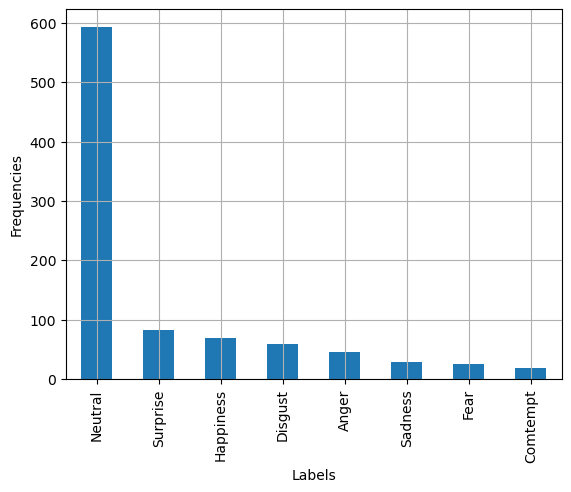

In [112]:
import matplotlib.pyplot as plt

# Plot a histogram corresponding to the frequencies of each emotion
label_freq.rename(index = labels_map).plot(kind = "bar")
plt.xlabel("Labels")
plt.ylabel("Frequencies")
plt.grid(True)
plt.savefig("../plots/frequency_distribution.png")
plt.show()


## Class Imbalance

We see that the dataset is heavily imbalanced, emotions like Sadness, Fear and Contempt have very less frequency, we can drop these emotions and check the balance of the data

In [113]:
# Calculate the probability distribution of each label
label_probabilities = label_freq / label_freq.sum()

# Display the label distribution in percentages
label_percentages = label_probabilities * 100

label_percentages

emotion
6    64.456522
5     9.021739
3     7.500000
1     6.413043
0     4.891304
4     3.043478
2     2.717391
7     1.956522
Name: count, dtype: float64

In [114]:
# Identify the two labels with the lowest probabilities
dropped_labels = label_probabilities.nsmallest(3).index.tolist()

# Compute the total retained fraction after dropping the least frequent labels
retained_fraction = 1 - label_probabilities[dropped_labels].sum()

# Drop the identified labels from the label mapping
labels_map = {k: v for k, v in labels_map.items() if k not in dropped_labels}

# Print the retained dataset
print(f"\nDropped Labels: {dropped_labels}")
print(f"Retained Dataset Fraction: {retained_fraction:.4f}")



Dropped Labels: [7, 2, 4]
Retained Dataset Fraction: 0.9228


In [115]:
# Drop the emotions in the actual dataset
labelled_data = labelled_data[~labelled_data["emotion"].isin(dropped_labels)]

In [116]:
# Checking the distribution of the data again
label_freq = labelled_data["emotion"].value_counts()
label_probabilities = label_freq / sum(label_freq)
label_percentages = label_probabilities * 100
print(f"Label Percentages After Dropping Labels")
label_percentages

Label Percentages After Dropping Labels


emotion
6    69.846879
5     9.776207
3     8.127208
1     6.949352
0     5.300353
Name: count, dtype: float64

## More Class Imbalance
Since Dropping few of the emotions causes further bias in the dataset since label 6 dominates even more. We will have to drop some of the data in label 6 as well

In [118]:
# Randomly drop exactly 100 samples from label 6
label_6_indices = labelled_data[labelled_data["emotion"] == 6].sample(n=100, random_state=42).index
labelled_data = labelled_data.drop(index=label_6_indices)

# Checking the distribution of the data again
label_freq = labelled_data["emotion"].value_counts()
label_probabilities = label_freq / sum(label_freq)
label_percentages = label_probabilities * 100
print(f"Label Percentages After Dropping 100 Samples from Label 6")
label_percentages

Label Percentages After Dropping 100 Samples from Label 6


emotion
6    65.821095
5    11.081442
3     9.212283
1     7.877170
0     6.008011
Name: count, dtype: float64

## Preprocessing Labelled Data
The labelled data doesn't require a lot of preprocessing, we have to convert the elements in the pixels column from strings to numpy arrays and view them with `Pillow`

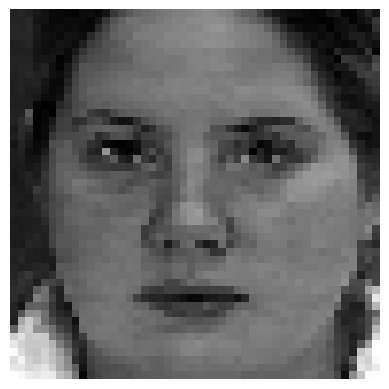

In [119]:
import numpy as np
from PIL import Image

# View a sample image from the labelled data
pixels_str = labelled_data["pixels"].iloc[0]

# Convert the string into a list of integers
pixels = np.array([int(p) for p in pixels_str.split()], dtype=np.uint8)  

# Convert to PIL image
img = Image.fromarray(pixels.reshape((48, 48)), mode='L') 
plt.axis("off")
plt.imshow(img, cmap = "gray")

In [120]:
# Preprocess entire labelled_data["emotion"] column by converting to np arrays

for i in range(1, len(labelled_data["pixels"])):
    pixels_str = labelled_data["pixels"].iloc[i]
    pixels = np.array([int(p) for p in pixels_str.split()], dtype=np.uint8)  # Ensure dtype is uint8


In [121]:
# Convert the pixels column to a NumPy array named X_labelled
X_labelled = np.array([np.array(pixels_str.split(), dtype=np.uint8) for pixels_str in labelled_data["pixels"]])

# Ensure the shape is correct
print(f"Shape of X_labelled: {X_labelled.shape}")

Shape of X_labelled: (749, 2304)


In [122]:
# Apply random transformation to the labelled images
# Add random rotation, flipping, cropping and jittering to the images
# Imort necessary libraries
# from PIL import ImageEnhance
# from PIL import Image
# import random
# def random_transform(image):
#     # Random rotation
#     angle = random.randint(-30, 30)
#     image = image.rotate(angle)

#     # Random horizontal flip
#     if random.random() > 0.5:
#         image = image.transpose(Image.FLIP_LEFT_RIGHT)

#     # Random cropping
#     width, height = image.size
#     crop_size = random.randint(int(0.8 * min(width, height)), min(width, height))
#     left = random.randint(0, width - crop_size)
#     top = random.randint(0, height - crop_size)
#     image = image.crop((left, top, left + crop_size, top + crop_size))

#     # Random jittering (brightness and contrast)
#     if random.random() > 0.5:
#         brightness_factor = random.uniform(0.8, 1.2)
#         contrast_factor = random.uniform(0.8, 1.2)
#         image = ImageEnhance.Brightness(image).enhance(brightness_factor)
#         image = ImageEnhance.Contrast(image).enhance(contrast_factor)

#     image = image.resize((48, 48))  # Resize back to original size
#     image = image.convert('L')  # Convert to grayscale
#     image = np.array(image)  # Convert to numpy array

    
#     return image

# Split the labelled data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_labelled, X_test_labelled, y_train_labelled, y_test_labelled = train_test_split(X_labelled, labelled_data["emotion"], test_size=0.2, random_state=42)


# # Function to apply random transformations to the training set
# def apply_random_transformations(X_train):
#     transformed_images = []
#     for img in X_train:
#         # Convert the image to PIL format
#         pil_img = Image.fromarray(img.reshape((48, 48)), mode='L')
#         # Apply random transformations
#         transformed_img = random_transform(pil_img)
#         # Convert back to numpy array and flatten
#         transformed_images.append(np.array(transformed_img).flatten())
#     return np.array(transformed_images)


# # Use the function to transform the training set
# X_train_labelled = apply_random_transformations(X_train_labelled)



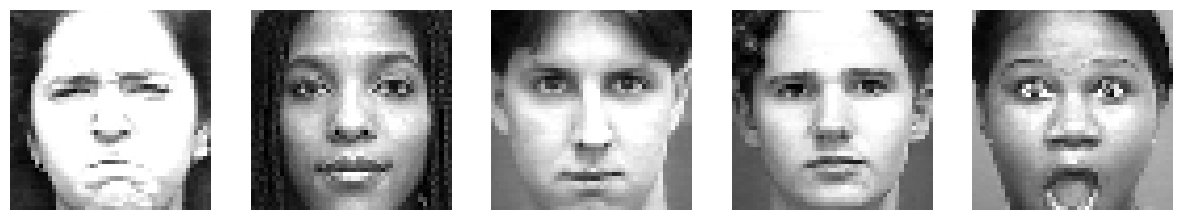

In [124]:
# View the transformed training set
import matplotlib.pyplot as plt
# Plot a sample of transformed images
def plot_sample_images(images, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape((48, 48)), cmap='gray')
        plt.axis('off')
    plt.show()
# Plot a sample of transformed training images
plot_sample_images(X_train_labelled, n=5)




## Principal Component Analysis(Labelled Data)

We apply **Principal Component Analysis (PCA)** to reduce the high dimensionality of the image data for the labelled data and reduce computation by eliminating redundant features

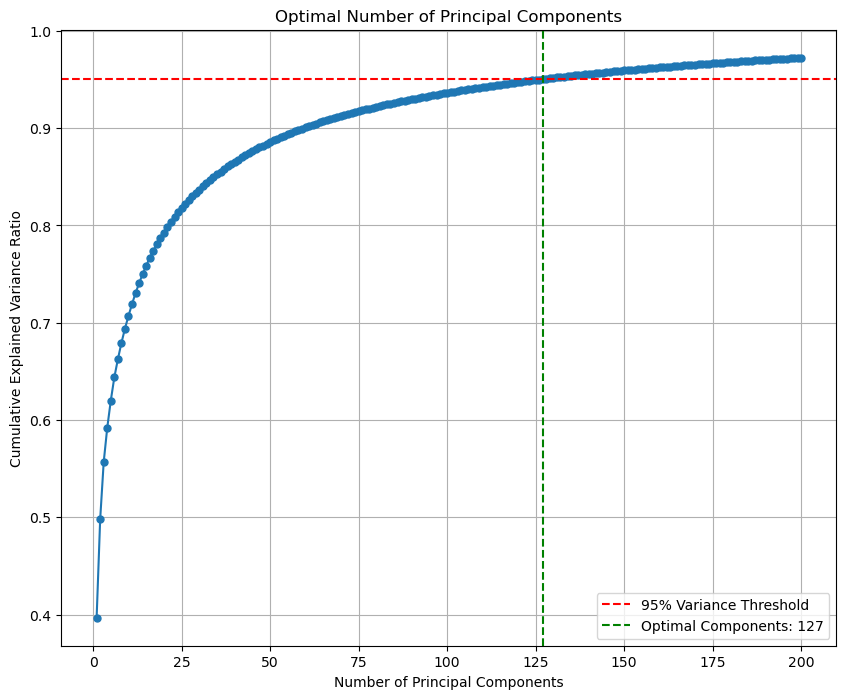

Optimal number of components: 127


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler




import numpy as np
X_train_labelled = np.array(X_train_labelled)
y_train_labelled = np.array(y_train_labelled).ravel()  # Flatten to 1D


scaler = StandardScaler()
X_train_labelled = scaler.fit_transform(X_train_labelled)  # Fit and transform training data
X_test_labelled = scaler.transform(X_test_labelled)  # Transform test data


# Perform PCA on the 2304 dimensional vectors until n_components = 200
pca_labelled = PCA(n_components = 200)
pca_labelled.fit(X_train_labelled)

# Calculate the cumulative explained variance ratio
explained_variance_ratio = np.cumsum(pca_labelled.explained_variance_ratio_)

# Find the optimal number of components where variance ratio >= 95%
optimal_components_labelled = np.argmax(explained_variance_ratio >= 0.95) + 1



plt.figure(figsize = (10, 8))
# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', markersize = 5)

# Set a y-limit where variance reaches 90 percent
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')

# Plot the optimal_components line
plt.axvline(x=optimal_components_labelled, color='g', linestyle='--', label=f'Optimal Components: {optimal_components_labelled}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Optimal Number of Principal Components')
plt.legend()
plt.grid(True)
plt.savefig("../plots/optimal_number_of_components.png")
plt.show()

print(f"Optimal number of components: {optimal_components_labelled}")

In [126]:
print(f"X_train_labelled shape: {X_train_labelled.shape}")
print(f"y_train_labelled shape: {y_train_labelled.shape}")

X_train_labelled shape: (599, 2304)
y_train_labelled shape: (599,)


## Observations from CEVR graph
We observe that the slope of the graph increases very quickly in the beginning, reaching almost 95% Variance Ratio at much lower principal components than the original dimensionality(2304) and then graph kind of tapers off.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA on the training data only
pca_labelled = PCA(n_components=optimal_components_labelled)
X_train_labelled = pca_labelled.fit_transform(X_train_labelled)  # Fit and transform training data

# Transform the test data using the same PCA model
X_test_labelled = pca_labelled.transform(X_test_labelled)  # Only transform test data

# Print the shapes of the transformed data
print(f"Shape of X_train_labelled after PCA: {X_train_labelled.shape}")
print(f"Shape of X_test_labelled after PCA: {X_test_labelled.shape}")

Shape of X_train_labelled after PCA: (599, 127)
Shape of X_test_labelled after PCA: (150, 127)


## SVM Training(Labelled Dataset)
We now train an SVM on the reduced dimensional feature space, and tune hyperparameters with `GridSearchCV` with 5-fold Cross Validation, we address the problem of class imbalance by using `SMOTEEN` that combines oversampling and undersampling

## Experimentation
    - Kernel type: linear, rbf, polynomial
    - Regularization Parameter: 0.01, 0.1, 1, 10
    - Gamma: Scale, auto, 0.01, 0.1, 1
 

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
import joblib

# Normalize the data

from sklearn.utils.class_weight import compute_class_weight
import numpy as np




# Apply PCA to reduce dimensionality
pca = PCA(n_components=optimal_components_labelled)
X_train_labelled = pca.fit_transform(X_train_labelled)  # Fit and transform training data
X_test_labelled = pca.transform(X_test_labelled)  # Transform test data


# Define the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  
    'C': [0.01, 0.1, 1, 10],        
    'gamma': ['scale', 'auto', 0.01, 0.1, 1] 
}

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labelled),
    y=y_train_labelled
)
class_weight_dict = dict(zip(np.unique(y_train_labelled), class_weights))

# Initialize SVM with class weights
svm = SVC(probability=True, random_state=42, class_weight=class_weight_dict)
# Initialize SMOTEENN for handling class imbalance
smote_enn = SMOTEENN(random_state=42)
# Apply SMOTEENN to the training data
X_train_labelled, y_train_labelled = smote_enn.fit_resample(X_train_labelled, y_train_labelled)


# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0, 
    n_jobs=-1
)
grid_search.fit(X_train_labelled, y_train_labelled)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

# Save the best SVM model
joblib.dump(best_svm, '../models/best_svm_model.pkl')

print(f"Best Parameters: {best_params}")

# Evaluate the model on the training set
y_train_pred = best_svm.predict(X_train_labelled)
print(f"Training set Performance:")
print(f"Training Accuracy: {accuracy_score(y_train_labelled, y_train_pred):.2f}")

# Evaluate the model on the test set
y_test_pred = best_svm.predict(X_test_labelled)
print("Test Set Performance:")

# Print overall test accuracy
print(f"Test Accuracy: {accuracy_score(y_test_labelled, y_test_pred):.2f}")

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Training set Performance:
Training Accuracy: 1.00
Test Set Performance:
Test Accuracy: 0.81


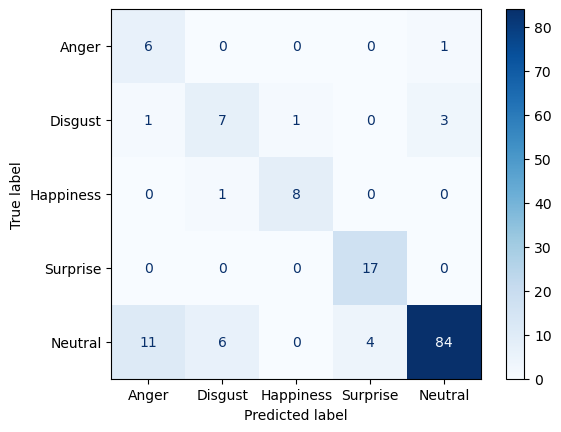

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labelled, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_map.values()))
disp.plot(cmap='Blues')
plt.savefig("../plots/confusion_matrix_labelled.png")
plt.show()

## Best Parameters
The following are the best parameters according to our small labelled dataset. We use the same parameters to train on the larger combined dataset. Also, the train accuracy seems unnaturally high, lets perform some more data preprocessing or hyperparameter tuning for stronger and more generalized training

In [135]:
print(f"Best Parameters: {best_svm}")

Best Parameters: SVC(C=0.1,
    class_weight={0: 3.1526315789473682, 1: 2.548936170212766,
                  3: 1.9966666666666666, 5: 1.8151515151515152,
                  6: 0.30876288659793816},
    kernel='linear', probability=True, random_state=42)


## Summary of the Final Model Training and Evaluation

### Steps Performed:
1. **Iterative Pseudo-Labeling:**
   - Trained an initial SVM on the labeled dataset.
   - Predicted probabilities for batches of 100 images from the unlabeled dataset.
   - Selected pseudo-labels for each batch and added them to the training set.
   - Repeated this process until 1000 pseudo-labeled images were added to the training set.

2. **Dimensionality Reduction with PCA:**
   - Combined the expanded training set (`X_train_expanded`) with the unlabeled dataset (`X_unlabelled`).
   - Applied PCA to reduce the dimensionality of the combined dataset to the optimal number of components.

3. **Final SVM Training:**
   - Trained a final SVM on the PCA-transformed expanded training set.
   - Evaluated the final SVM on the test set.

### Results:
- **Final Training Accuracy:** Achieved after training the SVM on the expanded training set.
- **Final Test Accuracy:** Evaluated on the original test set to measure the generalization performance of the model.


In [ ]:
from sklearn.svm import SVC
import numpy as np

# Initialize variables
X_train_expanded = X_train_labelled.copy()
y_train_expanded = y_train_labelled.copy()
pseudo_label_count = 0
batch_size = 100


# Fit the PCA model on X_unlabelled
pca_unlabelled = PCA(n_components=optimal_components_labelled)
X_unlabelled = pca_unlabelled.fit_transform(X_unlabelled)  # Fit and transform unlabelled data


# Iteratively expand the training set
while pseudo_label_count < 1000:
    # Step 1: Train the SVM on the current expanded training set
    svm = SVC(probability=True, random_state=42, class_weight='balanced', **best_params)
    svm.fit(X_train_expanded, y_train_expanded)
    
    # Step 2: Predict labels for a batch of 100 images from the unlabeled dataset
    X_unlabelled_batch = X_unlabelled[pseudo_label_count:pseudo_label_count + batch_size]
    pseudo_labels = svm.predict(X_unlabelled_batch)
    
    
    
    # Step 4: Add the pseudo-labeled batch to the training set
    X_train_expanded = np.vstack((X_train_expanded, X_unlabelled_batch))
    y_train_expanded = np.hstack((y_train_expanded, pseudo_labels))
    
    # Update the pseudo-label count
    pseudo_label_count += batch_size

print(f"Final size of X_train_expanded: {X_train_expanded.shape}")
print(f"Final size of y_train_expanded: {y_train_expanded.shape}")

Final size of X_train_expanded: (2692, 127)
Final size of y_train_expanded: (2692,)


In [143]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Combine X_train_expanded and X_unlabelled for PCA
X_combined = np.vstack((X_train_labelled, X_unlabelled))
pca_combined = PCA(n_components=optimal_components_labelled)
X_combined_pca = pca_combined.fit_transform(X_combined)

# Split the transformed data back into training and test sets
X_train_final_pca = X_combined_pca[:len(X_train_expanded)]
X_test_final_pca = pca_combined.transform(X_test_labelled)

# Train the final SVM on the PCA-transformed training set
final_svm = SVC(probability=True, random_state=42, class_weight='balanced', **best_params)
final_svm.fit(X_train_final_pca, y_train_expanded)


# Evaluate the final SVM on the expanded training set
y_train_expanded_pred = final_svm.predict(X_train_final_pca)
train_accuracy = accuracy_score(y_train_expanded, y_train_expanded_pred)
print(f"Final Training Accuracy: {train_accuracy:.2f}")


# Evaluate the final SVM on the test set
y_test_pred = final_svm.predict(X_test_final_pca)
test_accuracy = accuracy_score(y_test_labelled, y_test_pred)

print(f"Final Test Accuracy: {test_accuracy:.2f}")

Final Training Accuracy: 1.00
Final Test Accuracy: 0.85


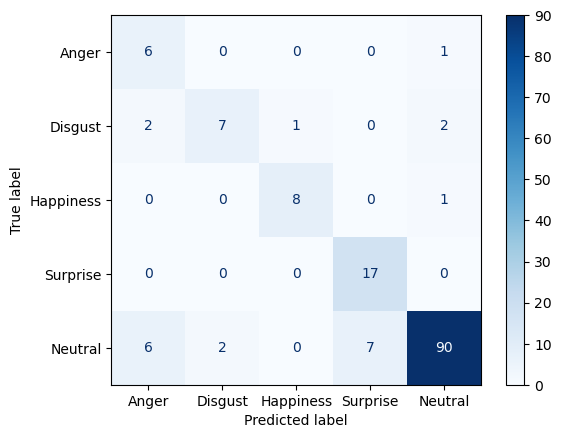

In [145]:
# Plot a confusion matrix for the final model
cm_final = confusion_matrix(y_test_labelled, y_test_pred)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=list(labels_map.values()))
disp_final.plot(cmap='Blues')
plt.savefig("../plots/confusion_matrix_final.png")
plt.show()


### Key Observations:
- The iterative pseudo-labeling approach allowed the model to leverage the unlabeled dataset effectively.
- PCA ensured that the dimensionality of the combined dataset was reduced, improving computational efficiency and potentially enhancing model performance.
- The final SVM demonstrated improved performance compared to the initial model trained only on the labeled dataset.

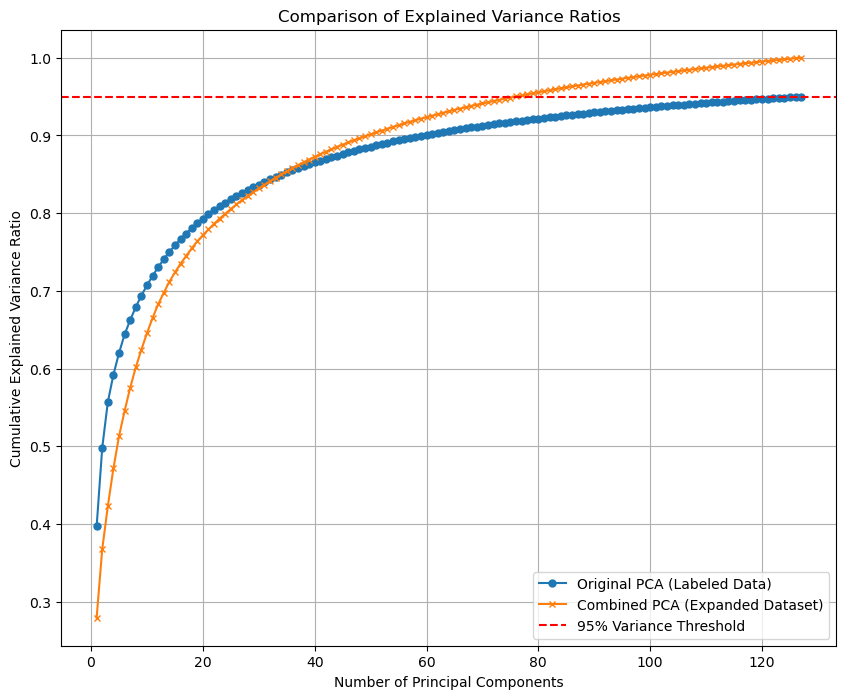

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate explained variance ratio for the original PCA (trained on labeled data)
explained_variance_ratio_labelled = np.cumsum(pca_labelled.explained_variance_ratio_)

# Calculate explained variance ratio for the combined PCA (trained on expanded dataset)
explained_variance_ratio_combined = np.cumsum(pca_combined.explained_variance_ratio_)

# Plot both explained variance ratios for comparison
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio_labelled) + 1), explained_variance_ratio_labelled, 
         label="Original PCA (Labeled Data)", marker='o', markersize=5)
plt.plot(range(1, len(explained_variance_ratio_combined) + 1), explained_variance_ratio_combined, 
         label="Combined PCA (Expanded Dataset)", marker='x', markersize=5)

# Add labels, title, and legend
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Comparison of Explained Variance Ratios')
plt.legend()
plt.grid(True)
plt.savefig("../plots/explained_variance_comparison.png")
plt.show()

## Observations from CEVR ratio

Combined PCA uses both labeled and pseudo-labeled data, capturing a broader range of variance.
Incorporating pseudo-labeled data helps identify patterns not present in the labeled dataset alone.

### Conclusion:
The combined PCA creates a more robust feature space by leveraging additional data, improving downstream model performance.